# Template for ML evaluation

There are a few features of the evaluation module, which are explained below. 

In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import sys
sys.path.append('../modules/')

%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-03-17 12:22:50.883784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-17 12:22:50.897062: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-17 12:22:50.901054: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# We need one place to save all the experiment relevant info.  
common_config= {'simulation_names':['DG','P2L'],  # What data sets to train on
                    'filter_scales':['50','100','200','400'], # What filter scales to train on
                    'window_size':1,  # What stencil we want to train on 
                    'all_ml_variables' : ['dudx_widened_rotated_nondim',  # must include all variables, inputs, outputs, 
                                          'dvdx_widened_rotated_nondim',  # including those used as coefficients (if you want to train y = coeff_var * ANN (x)
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim',
                                          'uphp_rotated_nondim',  # Note these non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated_nondim'], # And will require user to change SimulationData class if normalization needs changing
                    
                    'input_channels' :   ['dudx_widened_rotated_nondim',  # Inputs to ANN
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim'],
                    
                    'output_channels' :  ['uphp_rotated_nondim', # Outputs from ANN
                                          'vphp_rotated_nondim'],

                    'use_coeff_channels': False,
                    'coeff_channels'  : [],  # If any coefficients are used

                    'extra_channels'   : [  'uphp_rotated', # These are used during evaluation to go back to dimensional units. 
                                            'vphp_rotated', 
                                            'mag_nabla_h_widened',
                                            'mag_nabla_u_widened',
                                            'filter_scale'],

                    
                    'single_layer_mask': True, # A mask that says whether regions where only one dynamic layer is present should be masked out during training.

                    # The parameters below set how large the datasets need to be etc
                    'all_time_range': slice(0, 768),
                    'train_time_range': slice(0, 128*3),
                    'test_time_range' : slice(128*3, 128*4),
                    'eval_time_range' : slice(128*4, 128*5),
                    'num_train_batches': 3*8, # Each batch will have 16 snapshots
                    'num_test_batches' : 8, # Each batch will have 16 snapshots

                    #'num_inputs': 9*6, # Based on number of inputs and the stencil sizes
                    'num_inputs': 1*6, # Based on number of inputs and the stencil sizes
                    'network_shape': [48, 48, 2], #Shape of network

                    # Set location where the ckpt will be saved
                    'ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/template_trained/shape_48_48_2/'
                    
            }

In [4]:
DT = datasets.SimulationData(simulation_names=common_config['simulation_names'], 
                             filter_scales=common_config['filter_scales'], 
                             window_size = common_config['window_size'], 
                             time_sel = common_config['all_time_range'],
                             single_layer_mask_flag=common_config['single_layer_mask']
                             )

In [5]:
DT.simulation_data

DataTree('None', parent=None)
├── DataTree('DG')
│   ├── DataTree('50')
│   │       Dimensions:                      (Time: 768, xh: 200, yh: 218, zl: 2, Xn: 1,
│   │                                         Yn: 1, zi: 3)
│   │       Coordinates:
│   │         * Time                         (Time) object 6kB 0001-01-11 00:00:00 ... 00...
│   │         * xh                           (xh) float64 2kB 0.055 0.165 ... 21.84 21.95
│   │         * yh                           (yh) float64 2kB 30.14 30.23 ... 49.77 49.86
│   │         * zl                           (zl) float64 16B 1.035e+03 1.036e+03
│   │         * zi                           (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
│   │       Dimensions without coordinates: Xn, Yn
│   │       Data variables: (12/67)
│   │           dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 536MB dask.array<chunksize=(36, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 536MB dask.array<chunksize=(36, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 536MB dask.array<chunksize=(36, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dvdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 536MB dask.array<chunksize=(36, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dhdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 536MB dask.array<chunksize=(36, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dhdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 536MB dask.array<chunksize=(36, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           ...                           ...
│   │           uphp_rotated_nondim          (Time, zl, yh, xh) float64 536MB dask.array<chunksize=(36, 2, 218, 200), meta=np.ndarray>
│   │           vphp_rotated_nondim          (Time, zl, yh, xh) float64 536MB dask.array<chunksize=(36, 2, 218, 200), meta=np.ndarray>
│   │           uphp_nondim                  (Time, zl, yh, xh) float64 536MB dask.array<chunksize=(36, 2, 218, 200), meta=np.ndarray>
│   │           vphp_nondim                  (Time, zl, yh, xh) float64 536MB dask.array<chunksize=(36, 2, 218, 200), meta=np.ndarray>
│   │           Rd_nondim                    (Time, yh, xh) float64 268MB dask.array<chunksize=(36, 218, 200), meta=np.ndarray>
│   │           single_layer_mask            (Time, yh, xh) float64 268MB dask.array<chunksize=(36, 218, 200), meta=np.ndarray>
│   │       Attributes:
│   │           simulation_name:  DG
│   │           filter_scale:     50
│   │           source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
│   │           description:      Dataset for DG experiment at 50 km resolution
│   ├── DataTree('100')
│   │       Dimensions:                      (Time: 768, xh: 100, yh: 108, zl: 2, Xn: 1,
│   │                                         Yn: 1, zi: 3)
│   │       Coordinates:
│   │         * Time                         (Time) object 6kB 0001-01-11 00:00:00 ... 00...
│   │         * xh                           (xh) float64 800B 0.11 0.33 ... 21.67 21.89
│   │         * yh                           (yh) float64 864B 30.27 30.45 ... 49.55 49.73
│   │         * zl                           (zl) float64 16B 1.035e+03 1.036e+03
│   │         * zi                           (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
│   │       Dimensions without coordinates: Xn, Yn
│   │       Data variables: (12/67)
│   │           dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 133MB dask.array<chunksize=(36, 2, 108, 100, 1, 1), meta=np.ndarray>
│   │           dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 133MB dask.array<chunksize=(36, 2, 108, 100, 1, 1), meta=np.ndarray>
│   │           dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 133MB dask.array<chunksize=(36, 2, 108, 100, 1, 1), meta=np.ndarray>
│   │           dvdy_widened  

### Setting up the evaluation module and the basics

In [6]:
eval_sys = evaluation.EvalSystem(simulation_data=DT,
                                             input_channels=common_config['input_channels'],
                                             output_channels=common_config['output_channels'], 
                                             coeff_channels=common_config['coeff_channels'], 
                                             extra_channels=common_config['extra_channels'],
                                             use_norm_factors=True,
                                             eval_time_slice= common_config['eval_time_range'], 
                                             num_inputs= common_config['num_inputs'], 
                                             shape=common_config['network_shape'], 
                                             ckpt_dir=common_config['ckpt_save_dir'],
                                             use_coeff_channels=common_config['use_coeff_channels'])

In [7]:
eval_sys.read_ann_regression_model()
eval_sys.read_eval_data()
eval_sys.predict()
eval_sys.dimensionalize()

In [8]:
eval_sys.eval_datatree.ml_dataset

DataTree('None', parent=None)
├── DataTree('DG')
│   ├── DataTree('50')
│   │       Dimensions:                      (Time: 128, zl: 2, yh: 218, xh: 200, Xn: 1,
│   │                                         Yn: 1)
│   │       Coordinates:
│   │         * Time                         (Time) object 1kB 0015-01-18 00:00:00 ... 00...
│   │         * xh                           (xh) float64 2kB 0.055 0.165 ... 21.84 21.95
│   │         * yh                           (yh) float64 2kB 30.14 30.23 ... 49.77 49.86
│   │         * zl                           (zl) float64 16B 1.035e+03 1.036e+03
│   │       Dimensions without coordinates: Xn, Yn
│   │       Data variables: (12/18)
│   │           dudx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 89MB dask.array<chunksize=(28, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dvdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 89MB dask.array<chunksize=(28, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dudy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 89MB dask.array<chunksize=(28, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dvdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 89MB dask.array<chunksize=(28, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dhdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 89MB dask.array<chunksize=(28, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           dhdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 89MB dask.array<chunksize=(28, 2, 218, 200, 1, 1), meta=np.ndarray>
│   │           ...                           ...
│   │           filter_scale                 (yh, xh, Time) float64 45MB dask.array<chunksize=(218, 200, 28), meta=np.ndarray>
│   │           h_mask                       (Time, zl, yh, xh) float64 89MB dask.array<chunksize=(28, 2, 218, 200), meta=np.ndarray>
│   │           uphp_rotated_nondim_pred     (Time, zl, yh, xh) float64 89MB dask.array<chunksize=(28, 2, 218, 200), meta=np.ndarray>
│   │           vphp_rotated_nondim_pred     (Time, zl, yh, xh) float64 89MB dask.array<chunksize=(28, 2, 218, 200), meta=np.ndarray>
│   │           uphp_rotated_pred            (Time, zl, yh, xh) float64 89MB dask.array<chunksize=(28, 2, 218, 200), meta=np.ndarray>
│   │           vphp_rotated_pred            (Time, zl, yh, xh) float64 89MB dask.array<chunksize=(28, 2, 218, 200), meta=np.ndarray>
│   │       Attributes:
│   │           simulation_name:  DG
│   │           filter_scale:     50
│   │           source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
│   │           description:      Dataset for DG experiment at 50 km resolution
│   ├── DataTree('100')
│   │       Dimensions:                      (Time: 128, zl: 2, yh: 108, xh: 100, Xn: 1,
│   │                                         Yn: 1)
│   │       Coordinates:
│   │         * Time                         (Time) object 1kB 0015-01-18 00:00:00 ... 00...
│   │         * xh                           (xh) float64 800B 0.11 0.33 ... 21.67 21.89
│   │         * yh                           (yh) float64 864B 30.27 30.45 ... 49.55 49.73
│   │         * zl                           (zl) float64 16B 1.035e+03 1.036e+03
│   │       Dimensions without coordinates: Xn, Yn
│   │       Data variables: (12/18)
│   │           dudx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 22MB dask.array<chunksize=(28, 2, 108, 100, 1, 1), meta=np.ndarray>
│   │           dvdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 22MB dask.array<chunksize=(28, 2, 108, 100, 1, 1), meta=np.ndarray>
│   │           dudy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 22MB dask.array<chunksize=(28, 2, 108, 100, 1, 1), meta=np.ndarray>
│   │           dvdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 22MB dask.array<chunksize=(28, 2, 108, 100, 1, 1), meta=np.ndarray>
│   │           dhdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 22MB das

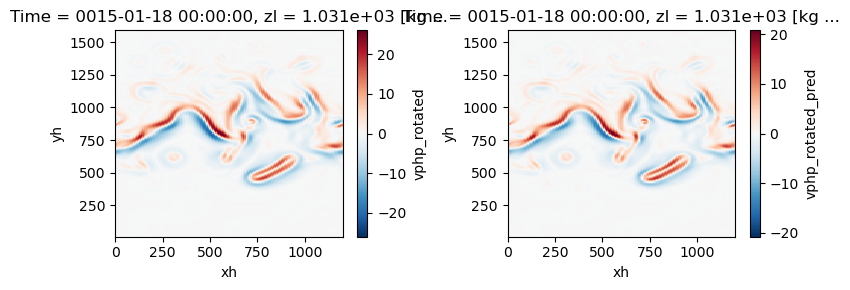

In [9]:
plt.figure(figsize=(8,3))

plt.subplot(121)
eval_sys.eval_datatree.ml_dataset['P2L']['50'].vphp_rotated.isel(Time=0, zl=0).plot()

plt.subplot(122)
eval_sys.eval_datatree.ml_dataset['P2L']['50'].vphp_rotated_pred.isel(Time=0, zl=0).plot()

plt.tight_layout()

### Calculating metrics

### Working with online data

In [10]:
ds_filt = DT.simulation_data['P2L']['100'].to_dataset()

In [11]:
ds_filt

<xarray.Dataset> Size: 4GB
Dimensions:                      (Time: 768, xh: 60, yh: 78, zl: 2, Xn: 1,
                                  Yn: 1, zi: 3)
Coordinates:
  * Time                         (Time) object 6kB 0001-01-11 00:00:00 ... 00...
  * xh                           (xh) float64 480B 10.0 30.0 ... 1.19e+03
  * yh                           (yh) float64 624B 30.0 50.0 ... 1.57e+03
  * zl                           (zl) float64 16B 1.031e+03 1.033e+03
  * zi                           (zi) float64 24B 1.03e+03 1.032e+03 1.034e+03
Dimensions without coordinates: Xn, Yn
Data variables: (12/67)
    dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 58MB dask.array<chunksize=(36, 2, 78, 60, 1, 1), meta=np.ndarray>
    dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 58MB dask.array<chunksize=(36, 2, 78, 60, 1, 1), meta=np.ndarray>
    dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 58MB dask.array<chunksize=(36, 2, 78, 60, 1, 1), meta=np.ndarray>
    dvdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 58MB dask.array<chunksize=(36, 2, 78, 60, 1, 1), meta=np.ndarray>
    dhdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 58MB dask.array<chunksize=(36, 2, 78, 60, 1, 1), meta=np.ndarray>
    dhdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 58MB dask.array<chunksize=(36, 2, 78, 60, 1, 1), meta=np.ndarray>
    ...                           ...
    uphp_rotated_nondim          (Time, zl, yh, xh) float64 58MB dask.array<chunksize=(36, 2, 78, 60), meta=np.ndarray>
    vphp_rotated_nondim          (Time, zl, yh, xh) float64 58MB dask.array<chunksize=(36, 2, 78, 60), meta=np.ndarray>
    uphp_nondim                  (Time, zl, yh, xh) float64 58MB dask.array<chunksize=(36, 2, 78, 60), meta=np.ndarray>
    vphp_nondim                  (Time, zl, yh, xh) float64 58MB dask.array<chunksize=(36, 2, 78, 60), meta=np.ndarray>
    Rd_nondim                    (Time, yh, xh, zl) float64 58MB dask.array<chunksize=(36, 78, 60, 2), meta=np.ndarray>
    single_layer_mask            (Time, yh, xh) float64 29MB dask.array<chunksize=(36, 78, 60), meta=np.ndarray>
Attributes:
    simulation_name:  P2L
    filter_scale:     100
    source:           gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/r...
    description:      Dataset for P2L experiment at 100 km resolution

In [23]:
dt_online = datasets.SimulationData(simulation_names=['P2L'], 
                             filter_scales=['100'], 
                             window_size = common_config['window_size'], 
                             single_layer_mask_flag=common_config['single_layer_mask'],
                             data_form = 'regular' ,
                             add_middle_interface = False,
                             add_layer_decomposition = False,
                             variables_to_widen = ['dudx','dvdx','dudy','dvdy','dhdx','dhdy']      
                             )

NameError: name 'variables_to_widen' is not defined

In [15]:
dt_online

DataTree('None', parent=None)
└── DataTree('P2L')
    └── DataTree('100')
            Dimensions:  (xq: 61, yh: 80, zl: 2, Time: 15, xh: 60, yq: 81, zi: 3)
            Coordinates:
              * xq       (xq) float64 488B 0.0 20.0 40.0 60.0 ... 1.16e+03 1.18e+03 1.2e+03
              * yh       (yh) float64 640B 10.0 30.0 50.0 ... 1.55e+03 1.57e+03 1.59e+03
              * zl       (zl) float64 16B 1.031e+03 1.033e+03
              * Time     (Time) object 120B 0001-01-11 00:00:00 ... 0001-05-31 00:00:00
              * xh       (xh) float64 480B 10.0 30.0 50.0 ... 1.15e+03 1.17e+03 1.19e+03
              * yq       (yq) float64 648B 0.0 20.0 40.0 60.0 ... 1.56e+03 1.58e+03 1.6e+03
              * zi       (zi) float64 24B 1.03e+03 1.032e+03 1.034e+03
            Data variables: (12/16)
                u        (Time, zl, yh, xq) float64 1MB ...
                v        (Time, zl, yq, xh) float64 1MB ...
                h        (Time, zl, yh, xh) float64 1MB ...
                e        (Time, zi, yh, xh) float64 2MB ...
                RV       (Time, zl, yq, xq) float64 1MB ...
                PV       (Time, zl, yq, xq) float64 1MB ...
                ...       ...
                dvdx     (Time, zl, yh, xh) float64 1MB ...
                dvdy     (Time, zl, yh, xh) float64 1MB ...
                Fx       (Time, zl, yh, xh) float64 1MB ...
                Fy       (Time, zl, yh, xh) float64 1MB ...
                uhTrANN  (Time, zl, yh, xq) float64 1MB ...
                vhTrANN  (Time, zl, yq, xh) float64 1MB ...
            Attributes:
                filename:         prog.nc
                title:            Phillips experiment
                grid_type:        regular
                grid_tile:        N/A
                simulation_name:  P2L
                filter_scale:     100
                source:           ~/mesoscale_buoyancy_param_ML/online_analysis_Greene/Ph...
                description:      Dataset for P2L experiment at 100 km resolution

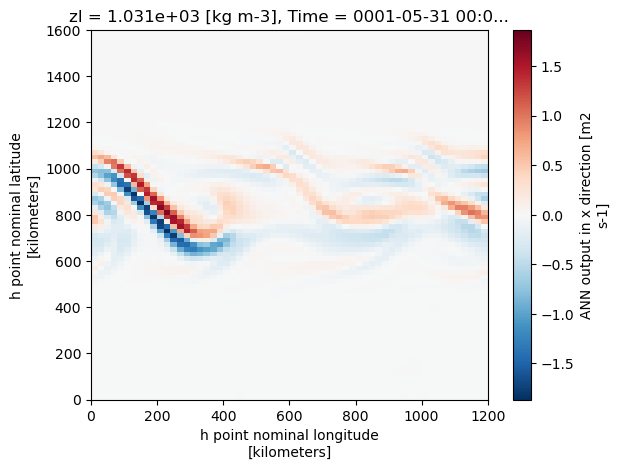

In [18]:
ds.Fx.isel(Time=-1, zl=0).plot()